# Viele Dateien

**Inhalt:** Massenverarbeitung von gescrapten Zeitreihen

**Nötige Skills:** Daten explorieren, Time+Date Basics

**Lernziele:**
- Pandas in Kombination mit Scraping
- Öffnen und zusammenfügen von vielen Dateien (Glob)
- Umstrukturierung von Dataframes (Pivot)
- Plotting Level 4 (Small Multiples)

## Das Beispiel

Wir interessieren uns in diesem Notebook für Krypto-Coins.

Die Webseite https://cryptocompare.com/ führt Marktdaten zu den wichtigsten Coins auf.

Via API beschaffen wir uns die Daten zu den 30 grössten davon:
- Erklär-Artikel: https://towardsdatascience.com/obtaining-historical-and-real-time-crypto-data-with-very-simple-web-programming-7b481f153630
- Dokumentation: https://min-api.cryptocompare.com/documentation

Der Pfad zum Projektordner heisst `dataprojects/Krypto/`. Dort ist auch der Scraper abgelegt.

Zu jeder Kryptowährung haben wir ein csv-Datenfile im Unterordner `data/`.

## Vorbereitung

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import re

In [4]:
import glob

## Daten laden

**In diesem Teil hat es einige neue Funktionen drin, die wir noch nicht kennen. Sie können sich einfach durchklicken.**

### Übersicht über die Währungen

In diesem File sind die 100 grössten Kryptowährungen nach Marktkapitalisierung abgelegt. Es dient hier nur als Referenz, wir arbeiten nicht weiter damit.

In [10]:
df_currencies = pd.read_csv("dataprojects/Krypto/100_currencies_new.csv")

Die 30 grössten davon, zu denen wir die Daten haben:

In [11]:
df_currencies.head(30)

,id,name,fullname,internal,marketcap
0,1182,BTC,Bitcoin,BTC,3.776719e+11
1,7605,ETH,Ethereum,ETH,1.907015e+11
2,171986,USDT,Tether,USDT,6.755040e+10
3,925809,USDC,USD Coin,USDC,5.187754e+10
4,204788,BNB,Binance Coin,BNB,4.492729e+10
5,5031,XRP,XRP,XRP,3.258652e+10
6,932135,BUSD,BUSD,BUSD,1.943322e+10
7,934443,SOL,Solana,SOL,1.666926e+10
8,321992,ADA,Cardano,ADA,1.635999e+10
9,935731,DOT,Polkadot,DOT,9.163780e+09


### Einlesen 1: ein einzelnes File

Zu jeder Kryptowährung gibt es eine Datei mit den Kursdaten. Wir laden testweise eines davon:

In [5]:
path = 'dataprojects/Krypto/'

In [6]:
df = pd.read_csv(path + 'data/BTC.csv')

In [7]:
df.head(2)

,date,open,high,low,close,volume,currency
0,2017-09-05,4267.45,4496.67,4004.62,4409.08,6.738468e+08,Bitcoin
1,2017-09-06,4409.08,4660.04,4401.53,4618.71,5.047172e+08,Bitcoin


In [8]:
df.tail(2)

,date,open,high,low,close,volume,currency
1825,2022-09-04,19834.79,20022.47,19591.33,20003.46,3.871492e+08,Bitcoin
1826,2022-09-05,20003.46,20051.73,19685.17,19782.48,2.042904e+08,Bitcoin


Das DF ist 1827 Einträge lang (das entspricht 1 Eintrag pro Tag während 5 Jahren)

In [9]:
len(df)

1827

Theoretisch könnten wir diesen Code jetzt für jede der 100 Währungen manuell wiederholen.

Doch das ist umständlich, wir wollen automatisch alle Währungen laden.

### Einlesen 2: Alle Files auf einmal

**Schritt 1: Liste von Dateinamen erstellen**

Wir starten damit, dass wir das Verzeichnis durchsuchen, in dem alle Kryptowährungs-Daten abgelegt sind.

Dazu benutzen wir `glob`, ein praktisches Tool aus der Standard Library: https://docs.python.org/3/library/glob.html

In [12]:
filenames = glob.glob(path + 'data/*.csv')

Check: Anzahl der Files

In [14]:
len(filenames)

30

Wir haben nun eine Liste von allen Dateinamen. Die ersten zwei Einträge sind:

In [15]:
filenames[0:2]

['dataprojects/Krypto/data/OP.csv', 'dataprojects/Krypto/data/BTC.csv']

**Schritt 2: Liste von Dataframes anhand der Dateinamen**

Nun lesen wir jede einzelne Datei aus der Liste ein - und zwar in eine **Liste von Dataframes**.

Diese Liste nennen wir `dfs[]`. Sie wird so viele Einträge haben wie es Währungen gibt, jedes davon ein Dataframe.

In [16]:
dfs = []

Zum Einlesen benutzen wir list comprehension...

In [17]:
dfs = [pd.read_csv(filename) for filename in filenames]

In [18]:
dfs[0].head(2)

,date,open,high,low,close,volume,currency
0,2017-09-05,0.0,0.0,0.0,0.0,0.0,Optimism
1,2017-09-06,0.0,0.0,0.0,0.0,0.0,Optimism


**Schritt 4: Die DFs untereinander in ein einziges DF reihen**

Nun fügen wir alle Dataframes zu einem einzigen, sehr langen Dataframe zusammen.

Dazu benutzen wir die Funktion `pd.concat()`: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html

In [19]:
df_all = pd.concat(dfs, ignore_index=True)

Das resultierende DF ist nun 30x länger als die einzelnen zuvor:

In [20]:
df_all.shape

(54810, 7)

In [21]:
df_all.head(2)

,date,open,high,low,close,volume,currency
0,2017-09-05,0.0,0.0,0.0,0.0,0.0,Optimism
1,2017-09-06,0.0,0.0,0.0,0.0,0.0,Optimism


In [22]:
df_all.tail(2)

,date,open,high,low,close,volume,currency
54808,2022-09-04,0.8892,0.8985,0.8724,0.8951,26153888.72,Polygon
54809,2022-09-05,0.8951,0.9029,0.8722,0.8744,13017908.73,Polygon


In [23]:
df_all.dtypes

date         object
open        float64
high        float64
low         float64
close       float64
volume      float64
currency     object
dtype: object

Wir haben nun ein ellenlanges Dataframe. What next?

### Daten arrangieren

Das hängt davon ab, was wir mit den Daten genau tun wollen.

Eine Option wäre: die verschiedenen Währungen miteinander zu vergleichen. 
- Welche Währung hat vom Tag X zum Tag Y wie stark zugelegt?

Dazu müssen wir das Dataframe zunächst umstellen, mit `pivot()`: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.pivot.html

In [24]:
df_pivoted = df_all.pivot(index='date', columns='currency', values='close')

Mit `pivot()` haben wir folgendes gemacht:
- Statt im "Long"-Format sind die Daten nun im "Wide"-Format
- Das heisst in diesem Fall: Wir haben es anhand der Währungen rearrangiert (`columns='currency'`)
- Die Währungen stehen jetzt nicht mehr *untereinander*, sondern *nebeneinander*
- Die Info, die wir für jede Währung ausgewählt haben, ist der Schlusskurs `values='Close'`)
- Das DF ist jetzt wieder nur noch 366 Zeilen lang.
- Index jeder Zeile ist ein Datum (`index='date'`)

In [25]:
df_pivoted.shape

(1827, 30)

In [26]:
df_pivoted.head(2)

currency,ApeCoin,Avalanche,Axie Infinity Shards,BUSD,Binance Coin,Bitcoin,Cardano,Chainlink,Cosmos,Dai,...,STEPN,Shiba Inu,Solana,Stellar,TRON,Tether,USD Coin,Uniswap Protocol Token,Wrapped Bitcoin,XRP
date,,,,,,,,,,,,,,,,,,,,,
2017-09-05,0.0,0.0,0.0,0.0,1.0170,4409.08,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01868,0.001908,1.02,0.0,0.0,0.0,0.2168
2017-09-06,0.0,0.0,0.0,0.0,0.9829,4618.71,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.02038,0.002034,1.02,0.0,0.0,0.0,0.2314


Nun verfügen wir über einen Index, bei dem eine Zeile jeweils einem einzigartigen Zeitpunkt entspricht.

Wir verschönern die Indexspalte noch etwas:

In [27]:
df_pivoted.rename_axis(None, inplace=True)

In [28]:
df_pivoted.head(2)

currency,ApeCoin,Avalanche,Axie Infinity Shards,BUSD,Binance Coin,Bitcoin,Cardano,Chainlink,Cosmos,Dai,...,STEPN,Shiba Inu,Solana,Stellar,TRON,Tether,USD Coin,Uniswap Protocol Token,Wrapped Bitcoin,XRP
2017-09-05,0.0,0.0,0.0,0.0,1.0170,4409.08,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01868,0.001908,1.02,0.0,0.0,0.0,0.2168
2017-09-06,0.0,0.0,0.0,0.0,0.9829,4618.71,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.02038,0.002034,1.02,0.0,0.0,0.0,0.2314


Achtung: Manche Währungen existieren noch nicht so lange. Zum Beispiel:

<AxesSubplot:>

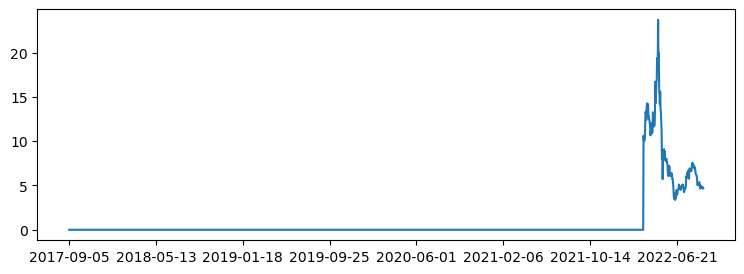

In [29]:
df_pivoted['ApeCoin'].plot(figsize=(9,3))

Für ein sauberes Dataframe müssen wir noch alle 0-Werte mit "nan" ersetzen:

In [30]:
df_pivoted = df_pivoted.replace(0, np.nan)

Wir haben nun ein sauber formatiertes Dataframe, das für jede Kryptowährung, sofern sie zum betreffenden Zeitpunkt existierte, einen Handelskurs enthält.

**Grossartig! Wir sind damit bereit für die Datenanalyse. Ab hier sind Sie an der Reihe...**

## Analyse

### Vorbereitung

Remember: Mit welchem Typ von Daten haben wir es hier zu tun...?

In [31]:
df_pivoted.index

Index(['2017-09-05', '2017-09-06', '2017-09-07', '2017-09-08', '2017-09-09',
       '2017-09-10', '2017-09-11', '2017-09-12', '2017-09-13', '2017-09-14',
       ...
       '2022-08-27', '2022-08-28', '2022-08-29', '2022-08-30', '2022-08-31',
       '2022-09-01', '2022-09-02', '2022-09-03', '2022-09-04', '2022-09-05'],
      dtype='object', length=1827)

... genau: mit einer Zeitreihe.

Um damit zu arbeiten, müssen wir den Text in der Indexspalte in ein echtes Datum umwandeln.

In [32]:
df_pivoted.index = pd.to_datetime(df_pivoted.index)

Und wir müssen den Datums-Index aufsteigend sortieren.

In [33]:
df_pivoted.sort_index(inplace=True)

In [34]:
df_pivoted.head(2)

currency,ApeCoin,Avalanche,Axie Infinity Shards,BUSD,Binance Coin,Bitcoin,Cardano,Chainlink,Cosmos,Dai,...,STEPN,Shiba Inu,Solana,Stellar,TRON,Tether,USD Coin,Uniswap Protocol Token,Wrapped Bitcoin,XRP
2017-09-05,NaN,NaN,NaN,NaN,1.0170,4409.08,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.01868,0.001908,1.02,NaN,NaN,NaN,0.2168
2017-09-06,NaN,NaN,NaN,NaN,0.9829,4618.71,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.02038,0.002034,1.02,NaN,NaN,NaN,0.2314


Die nächste Frage ist: Wie vergleichen wir diese Kurse? Was sagt es aus, wenn eine Währung an einem bestimmten Tag zu 0,1976 USD gehandelt wurde und eine andere zu 18,66 USD?

### Vergleichbarkeit herstellen

Diverse Dinge würden sich hier anbieten:
- zB `pct_change()` um die Veränderungen in den Kursen zu analysieren
- oder eine indexierte Zeitreihe, die an einem bestimmten Tag bei 100 beginnt

Wir wählen die zweite Variante.

Wählen Sie einen bestimmten Tag X: Dieser Tag ist das Startdatum für den Vergleich.

In [41]:
# Beispiel: 1 Jahr bevor die Daten enden
day_x = "2021-09-05"

Wie lesen Sie die entsprechende Zeile aus dem Dataframe für diesen Tag aus?

In [42]:
row_x = df_pivoted.loc[day_x]

Dann teilen wir jede einzelne Zeile im Dataframe durch die Tag-X-Zeile und multiplizieren sie mit 100. Speichern wir das Ergebnis als neues DF ab.

In [39]:
df_pivoted_100 = df_pivoted / row_x * 100

Das neue Dataframe müsste nun indexiert auf 100 sein: Alle Währungen starten am gleichen Punkt.

Stimmt das wirklich? Schauen Sie sich den Tag X an, um sicher zu sein...

In [43]:
df_pivoted_100[day_x:day_x]

currency,ApeCoin,Avalanche,Axie Infinity Shards,BUSD,Binance Coin,Bitcoin,Cardano,Chainlink,Cosmos,Dai,...,STEPN,Shiba Inu,Solana,Stellar,TRON,Tether,USD Coin,Uniswap Protocol Token,Wrapped Bitcoin,XRP
2021-09-05,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,NaN,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


### Auswertung

Jetzt wählen wir einen Tag Y für den Endzeitpunkt der Auswertung.

In [44]:
day_y = "2022-09-05"

Wenn wir uns das DF an diesem Tag anschauen, wissen wir, wie sich die Kurse der Währungen verändert haben.

In [45]:
df_pivoted_100.loc[day_y]

currency
ApeCoin                          NaN
Avalanche                  38.895807
Axie Infinity Shards       17.111975
BUSD                      100.010001
Binance Coin               54.552299
Bitcoin                    38.201798
Cardano                    16.721593
Chainlink                  21.331546
Cosmos                     49.068323
Dai                        99.990000
Dogecoin                   19.726550
Ethereum                   39.630800
FTX Token                  41.117231
LEO Token                 173.212487
Litecoin                   25.841439
Near                       68.153696
OKX                        66.681204
Optimism                         NaN
Polkadot                   21.858844
Polygon                    52.016657
STEPN                            NaN
Shiba Inu                 163.708609
Solana                     22.299627
Stellar                    26.180905
TRON                       59.876426
Tether                     99.990000
USD Coin                  100

Wir speichern diese Zeile in einer neuen Series und subtrahieren 100 - so erhalten wir die prozentuale Veränderung.

In [49]:
s_y = df_pivoted_100.loc[day_y] - 100

Welche zehn Kryptowährungen haben am meisten Wert gewonnen?

In [50]:
s_y.sort_values(ascending=False).head(10)

currency
LEO Token       73.212487
Shiba Inu       63.708609
BUSD             0.010001
USD Coin         0.000000
Tether          -0.010000
Dai             -0.010000
Near           -31.846304
OKX            -33.318796
TRON           -40.123574
Binance Coin   -45.447701
Name: 2022-09-05 00:00:00, dtype: float64

Welche haben am wenigsten Wert gewonnen (bzw. am meisten verloren)?

In [51]:
s_y.sort_values(ascending=False, na_position='first').tail(10)

currency
Stellar                  -73.819095
Litecoin                 -74.158561
XRP                      -75.179801
Solana                   -77.700373
Polkadot                 -78.141156
Uniswap Protocol Token   -78.495063
Chainlink                -78.668454
Dogecoin                 -80.273450
Axie Infinity Shards     -82.888025
Cardano                  -83.278407
Name: 2022-09-05 00:00:00, dtype: float64

### Plots

Erstellen Sie einen einfachen Linienplot mit den relativen Kursen aller Währungen (Start bei 100).

<AxesSubplot:title={'center':'Relative Entwicklung der Kurse'}>

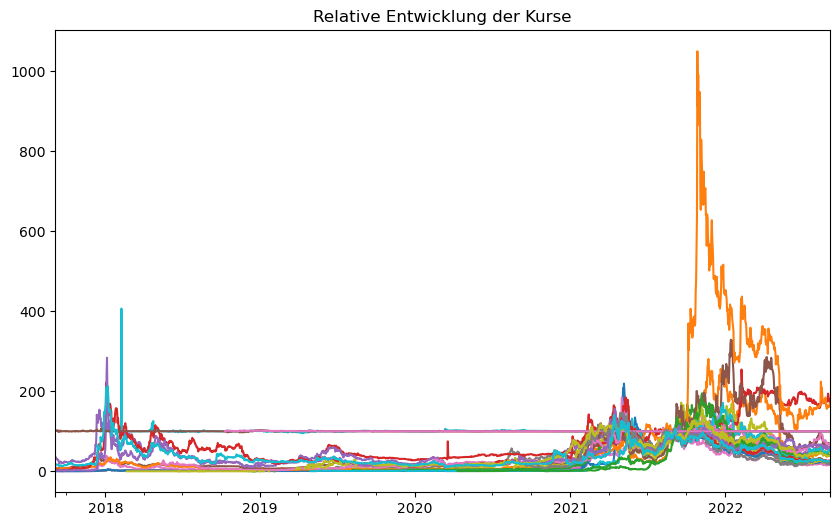

In [52]:
df_pivoted_100.plot(figsize=(10,6), legend=False, title='Relative Entwicklung der Kurse')

Wow, das sind ziemlich viele Linien! Beschränken wir uns mal auf die Kryptowährungen, für die wir effektiv durchgehend Daten haben:

In [53]:
firstline = df_pivoted_100.loc['2017-09-05']

In [54]:
valid_currencies = firstline[~firstline.isnull()].index

In [55]:
valid_currencies

Index(['Binance Coin', 'Bitcoin', 'Dogecoin', 'Ethereum', 'Litecoin',
       'Stellar', 'TRON', 'Tether', 'XRP'],
      dtype='object', name='currency')

Sie können die Spalten im Dataframe mit den relativen Kursen nun anhand dieser Liste filtern.

In [56]:
df_pivoted_100[valid_currencies]

currency,Binance Coin,Bitcoin,Dogecoin,Ethereum,Litecoin,Stellar,TRON,Tether,XRP
2017-09-05,0.201510,8.514341,0.643243,8.044369,31.733666,4.693467,1.813688,102.00,16.587605
2017-09-06,0.194753,8.919156,0.645787,8.575195,35.052079,5.120603,1.933460,102.00,17.704667
2017-09-07,0.273435,8.951772,0.635930,8.485374,34.539898,5.097990,1.721483,101.00,17.375669
2017-09-08,0.201114,8.354775,0.572337,7.760486,31.501248,4.595477,2.064639,101.00,16.235654
2017-09-09,0.190097,8.371537,0.549444,7.686352,30.597400,4.494975,2.685361,101.80,16.296863
...,...,...,...,...,...,...,...,...,...
2022-09-01,55.136817,38.872756,19.831479,40.127722,24.778342,26.407035,60.152091,99.99,25.485845
2022-09-02,54.974341,38.539662,19.605723,39.872936,26.263235,26.281407,59.505703,100.00,25.348125
2022-09-03,55.061523,38.302813,19.942766,39.408147,25.901696,26.432161,59.980989,100.00,25.218057
2022-09-04,55.307218,38.628530,20.104928,39.952636,26.220195,26.708543,60.370722,100.00,25.378730


Plotten Sie nun ausschliesslich die Entwicklung der ausgewählten Währungen.

<AxesSubplot:title={'center':'Relative Entwicklung der Kurse'}>

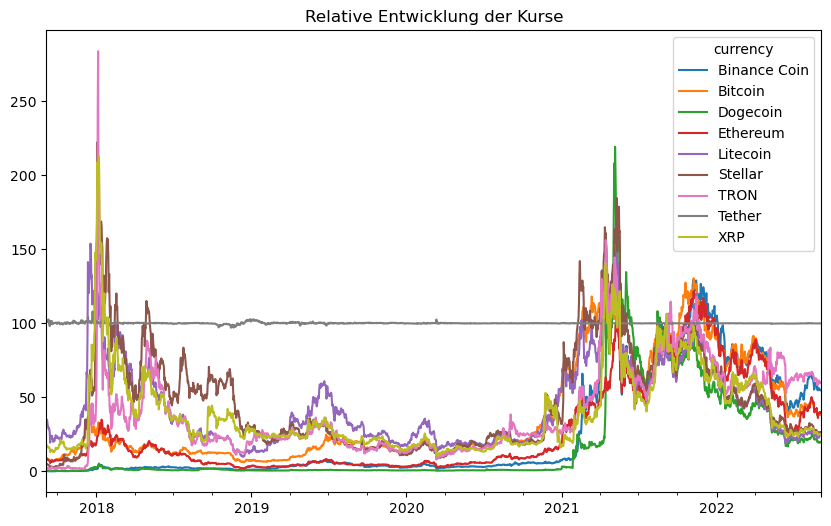

In [57]:
df_pivoted_100[valid_currencies].plot(figsize=(10,6), legend=True, title='Relative Entwicklung der Kurse')

Was fällt Ihnen auf?

In [58]:
# Die meisten Währungen verlaufen parallel
# Einzelne verhalten sich ganz anders (zB Tether, ein Stablecoin)

# Plotting Level 4

**Hier geht es wieder gemütlicher zu und her - Sie können sich durchklicken und müssen nichts programmieren.**

Inhalt dieser Plotting-Lektion:

- Wir lernen, wie "Small Multiples" geht
- Wir sehen, wie man die matplotlib-Funktionen direkt benutzen kann.

Dazu importieren wir erstmal ein paar Libraries...

In [59]:
import matplotlib.pyplot as plt

In [60]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

... und laden eine Datei, welche das Ergebnis der bisherigen Übung enthält (die relativen Kurse aller Währungen - normalisiert zum Tag X).

In [61]:
# df_pivoted_100.to_csv(path + 'Close_indexed_to_100.csv')

In [62]:
df_relative = pd.read_csv(path + 'Close_indexed_to_100.csv', index_col=0)
df_relative.index = pd.to_datetime(df_relative.index)

In [65]:
df_relative.head()

,ApeCoin,Avalanche,Axie Infinity Shards,BUSD,Binance Coin,Bitcoin,Cardano,Chainlink,Cosmos,Dai,...,STEPN,Shiba Inu,Solana,Stellar,TRON,Tether,USD Coin,Uniswap Protocol Token,Wrapped Bitcoin,XRP
2017-09-05,NaN,NaN,NaN,NaN,0.201510,8.514341,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.693467,1.813688,102.0,NaN,NaN,NaN,16.587605
2017-09-06,NaN,NaN,NaN,NaN,0.194753,8.919156,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.120603,1.933460,102.0,NaN,NaN,NaN,17.704667
2017-09-07,NaN,NaN,NaN,NaN,0.273435,8.951772,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.097990,1.721483,101.0,NaN,NaN,NaN,17.375669
2017-09-08,NaN,NaN,NaN,NaN,0.201114,8.354775,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.595477,2.064639,101.0,NaN,NaN,NaN,16.235654
2017-09-09,NaN,NaN,NaN,NaN,0.190097,8.371537,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.494975,2.685361,101.8,NaN,NaN,NaN,16.296863


### Ein Plot

Starten wir zuerst mal mit einem Plot: Bitcoin.

Technisch gesehen besteht jede Matplotlib-/Pandas-Grafik aus zwei Dingen:
1. Eine "figure", also eine Abbildung, gewissermassen das Blatt Papier
1. Ein "subplot", also der einzelne Plot selbst, pro "Papier" können es auch mehrere sein

<AxesSubplot:title={'center':'Bitcoin'}>

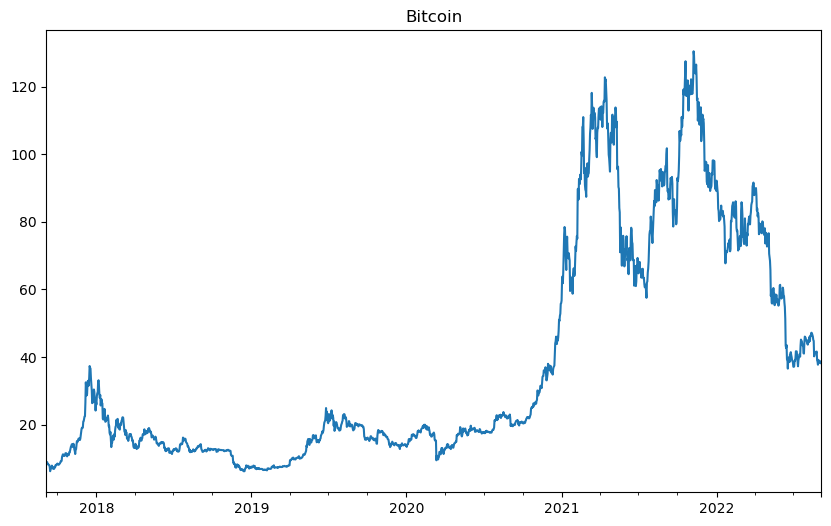

In [66]:
# Wir erstellen beide Dinge in einem Atemzug: figure und subplot
fig, ax = plt.subplots(figsize=(10,6))

# Und füllen den Plot jetzt mit Inhalt:
df_relative['Bitcoin'].plot(title="Bitcoin", ax=ax)

### Zwei Plots

Als nächstes Plotten wir zwei Währungen auf derselben Figure: Bitcoin und Ethereum.

Wir müssen uns dazu erneut zwei Dinge basteln:
1. Eine "figure", also eine Abbildung
1. Diverse "subplots" für die jeweiligen Währungen

Dazu formatieren wir jetzt die x-Achse etwas speziell.

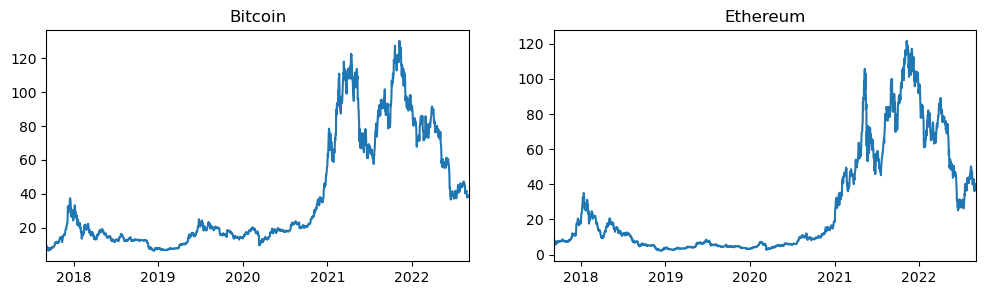

In [67]:
# Zuerst kreieren wir nur die Figure
fig = plt.figure(figsize=(12,3))

# Danach die einzelnen Subplots
ax1 = fig.add_subplot(1, 2, 1) # total 1 Zeile, total 2 Spalten, Subplot Nr. 1
ax2 = fig.add_subplot(1, 2, 2) # total 1 Zeile, total 2 Spalten, Subplot Nr. 2

# Und schliesslich füllen wir die Subplots mit Inhalt
df_relative['Bitcoin'].plot(title="Bitcoin", ax=ax1)
df_relative['Ethereum'].plot(title="Ethereum", ax=ax2)

# Hier formatieren wir die x-Achse für Plot 1
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_minor_locator(ticker.NullLocator())

# Hier formatieren wir die x-Achse für Plot 2
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.xaxis.set_minor_locator(ticker.NullLocator())

Einige Angaben dazu, wie man Zeitachsen formatieren kann, gibt es hier:
- TickLocators: https://matplotlib.org/examples/ticks_and_spines/tick-locators.html
- TickFormatters: https://matplotlib.org/gallery/ticks_and_spines/tick-formatters.html

### Sehr viele Plots

Nun plotten wir sämtliche Währungen, die keine "NaN"-Werte enthalten, auf einmal.

Dazu isolieren wir erst kurz die letzte Zeile.

In [68]:
s_last = df_relative.iloc[-1]

Wie viele Währungen sind nicht "NaN"?

In [69]:
anzahl_charts = s_last.notnull().sum()
anzahl_charts

27

Wir sortieren unsere Liste der Währungen anhand der letzten Zeile etwas:

In [70]:
sortierte_waehrungen = s_last[s_last.notnull()].sort_values(ascending=False)
sortierte_waehrungen.head(2)

LEO Token    173.212487
Shiba Inu    163.708609
Name: 2022-09-05 00:00:00, dtype: float64

Und wiederholen dann wiederum dasselbe Vorgehen wie vorher.

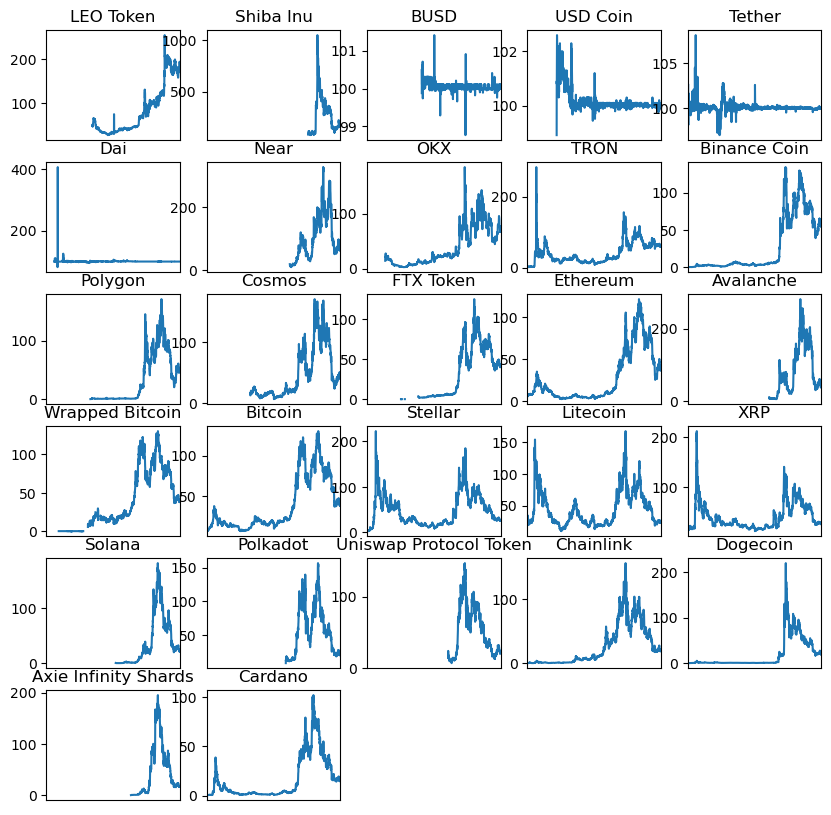

In [77]:
# Eine Abbildung, die gross genug ist
fig = plt.figure(figsize=(10,10))

# Und nun, für jede einzelne Währung einen Subplot:
for i, waehrung in enumerate(sortierte_waehrungen.index):
    
    # einen Subplot kreieren ... ()
    ax = fig.add_subplot(6, 5, i + 1)

    # ... und mit Inhalt füllen
    df_pivoted_100[waehrung].plot(title=waehrung, ax=ax)
    
    # Auf Ticks verzichten wir hier ganz
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.xaxis.set_minor_locator(ticker.NullLocator())

Falls wir zusätzlich noch wollen, dass jeder Plot dieselbe y-Achse hat:

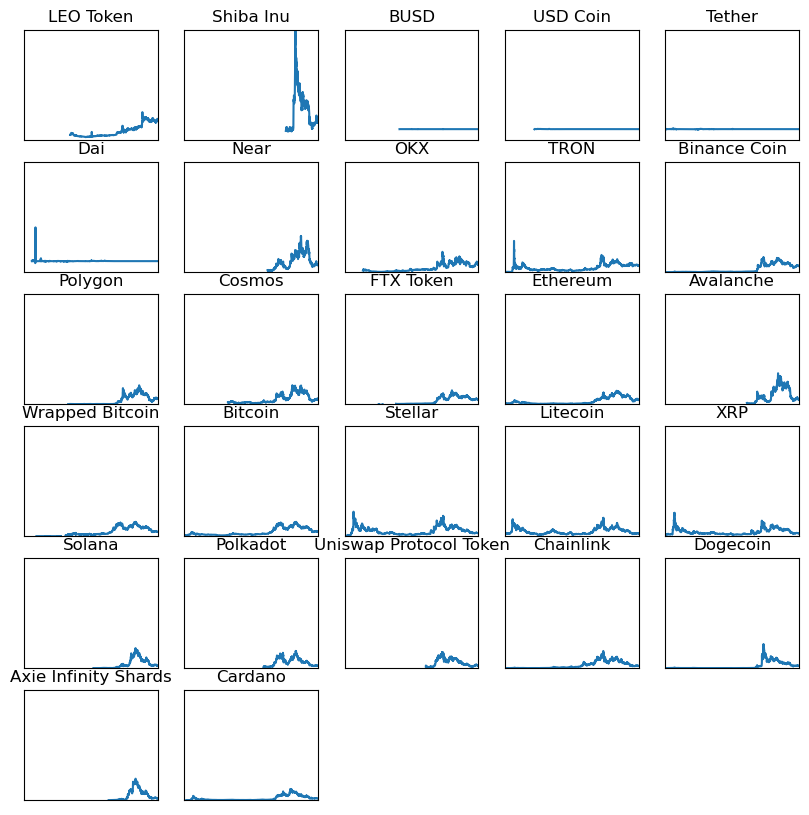

In [81]:
# Eine Abbildung, die gross genug ist
fig = plt.figure(figsize=(10, 10))

# Und nun, für jede einzelne Währung:
for i, waehrung in enumerate(sortierte_waehrungen.index):
    
    # einen Subplot kreieren ...
    ax = fig.add_subplot(6,5, i + 1)

    # ... und mit Inhalt füllen
    df_pivoted_100[waehrung].plot(title=waehrung, ax=ax)
    
    # Auf Ticks verzichten wir hier ganz
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.xaxis.set_minor_locator(ticker.NullLocator())
    
    # Hier setzen wir eine einheitliche y-Achse (und schalten sie aus)
    ax.set_ylim([0, 1000])
    ax.yaxis.set_major_locator(ticker.NullLocator())

### Aber es geht auch einfacher...

Ha! Nachdem wir nun alles Manuell zusammengebastelt haben, mit Matplotlib, hier die gute Nachricht:

*Wir können das mit wenigen Codezeilen auch direkt aus der Pandas-Plot()-Funktion haben :-)*

Die entscheidenden Parameter in der `plot()`-Funktion sind hier:
- `subplots=True` (zeichnet small multiples statt alles nur auf einem Chart)
- `sharey=True` (alle Subplots sollen dieselbe y-Achse verwenden)

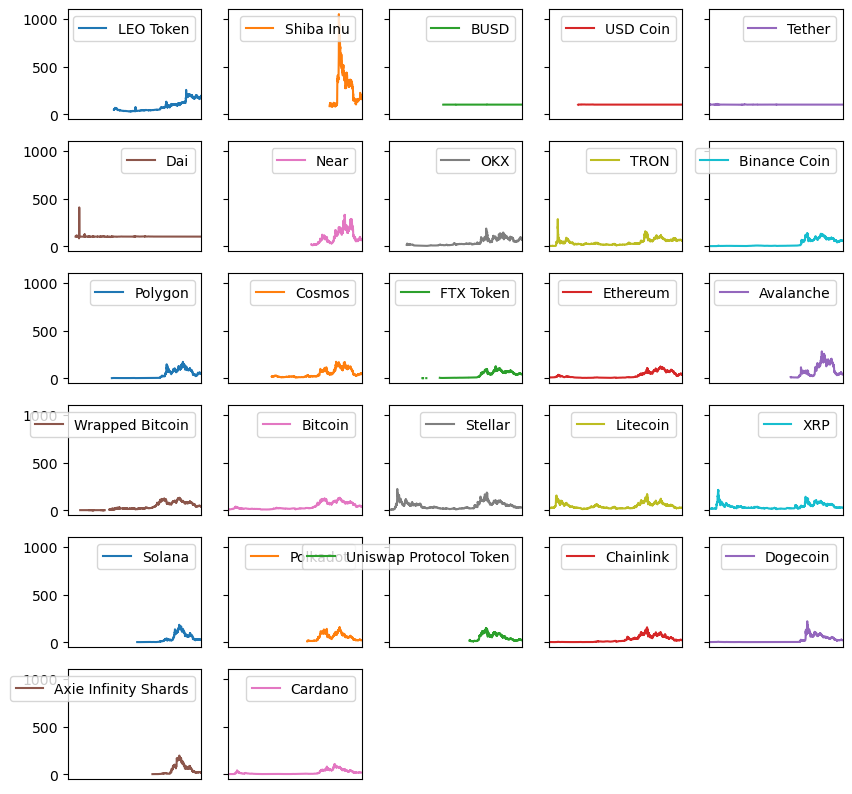

In [83]:
axes = df_pivoted_100[sortierte_waehrungen.index].plot(subplots=True,layout=(6, 5), sharey=True, figsize=(10, 10))

axes[0,0].xaxis.set_major_locator(ticker.NullLocator())
axes[0,0].xaxis.set_minor_locator(ticker.NullLocator())

# Übung

**In dieser letzten Sektion haben Sie nochmals Gelegenheit, alles zu üben – Daten arrangieren, analysieren, plotten**

Hier schauen wir uns nicht mehr die Handelskurse, sondern die Handelsvolumen an! Also: Wie viel von den einzelnen Kryptowährungen an einem bestimmten Tag gekfauft und verkauft wurde (gemessen in USD).

Schauen Sie sich nochmals das Dataframe `df_all` an, das wir im Verlauf des Notebooks erstellt haben - es enthält alle Informationen, die wir brauchen, ist aber noch relativ unstrukturiert.

In [84]:
df_all.tail(2)

,date,open,high,low,close,volume,currency
54808,2022-09-04,0.8892,0.8985,0.8724,0.8951,26153888.72,Polygon
54809,2022-09-05,0.8951,0.9029,0.8722,0.8744,13017908.73,Polygon


Welche Spalte interessiert uns? Müssen wir noch etwas daran machen?

In [85]:
# Uns interessiert die Spalte "volume"

### Daten arrangieren

Nun wollen wir die Daten umgliedern:
- Für jedes Datum wollen wir eine Zeile
- Für jede Kryptowährung eine Spalte
- Wir interessieren uns für die Handelsvolumen

In [86]:
df_pivoted2 = df_all.pivot(index='date', columns='currency', values='volume')

In [87]:
df_pivoted2.head(2)

currency,ApeCoin,Avalanche,Axie Infinity Shards,BUSD,Binance Coin,Bitcoin,Cardano,Chainlink,Cosmos,Dai,...,STEPN,Shiba Inu,Solana,Stellar,TRON,Tether,USD Coin,Uniswap Protocol Token,Wrapped Bitcoin,XRP
date,,,,,,,,,,,,,,,,,,,,,
2017-09-05,0.0,0.0,0.0,0.0,8794.19,6.738468e+08,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,875362.38,3099.60,1361171.09,0.0,0.0,0.0,15405037.13
2017-09-06,0.0,0.0,0.0,0.0,19508.65,5.047172e+08,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,632484.05,14988.43,797933.70,0.0,0.0,0.0,14069400.24


Formatieren Sie die Werte in der Index-Spalte als Datetime-Objekte und sortieren Sie das Dataframe nach Datum.

In [88]:
df_pivoted2.rename_axis(None, inplace=True)

In [89]:
df_pivoted2.index = pd.to_datetime(df_pivoted.index, format="%b %d, %Y")

In [90]:
df_pivoted2.sort_index(inplace=True)

Ersetzen Sie schliesslich alle 0-Werte durch nan-Werte

In [91]:
df_pivoted2 = df_pivoted2.replace(0, np.nan)

### Analyse

Wir machen in dieser Sektion einige einfache Auswertungen und repetieren einige Befehle, u.a. aus dem Time Series Sheet.

**Top-10**: Welches waren, im Schnitt, die zehn meistgehandelten Währungen? Liste und Chart.

In [92]:
df_pivoted2.mean().sort_values(ascending=False).head(10)

currency
Bitcoin         9.905507e+08
Ethereum        6.775032e+08
Solana          1.911892e+08
Litecoin        1.420755e+08
Optimism        1.083633e+08
ApeCoin         1.043213e+08
XRP             8.537756e+07
Shiba Inu       7.415939e+07
STEPN           7.217492e+07
Binance Coin    6.040185e+07
dtype: float64

<AxesSubplot:ylabel='currency'>

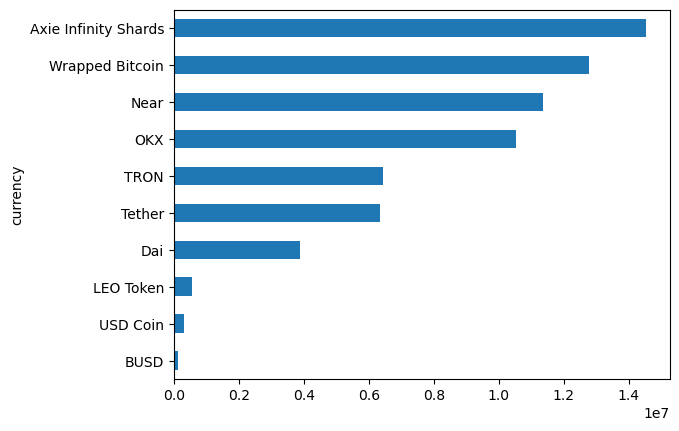

In [94]:
df_pivoted2.mean().sort_values().head(10).plot(kind='barh')

Welches waren die zehn Währungen, bei denen das Volumen in absoluten Zahlen am meisten geschwankt ist? (Standardabweichung)

<AxesSubplot:ylabel='currency'>

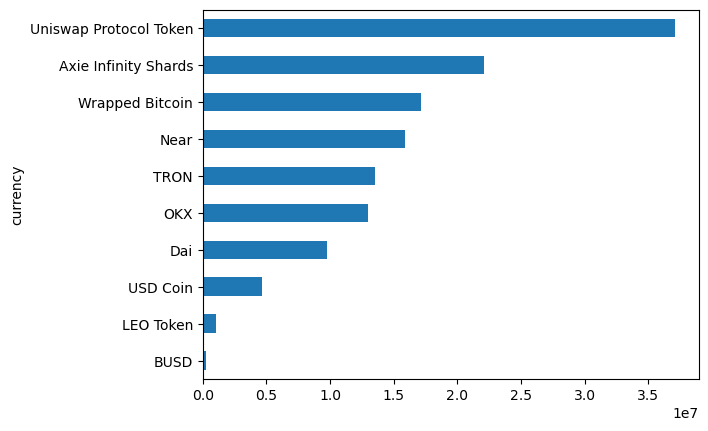

In [96]:
df_pivoted2.std().sort_values().head(10).plot(kind='barh')

**Bitcoin vs Ethereum**

Erstellen Sie einen Chart mit dem wöchentlichen Umsatztotal von Bitcoin und Ethereum!

Tipp: Resampling benutzen!

<AxesSubplot:>

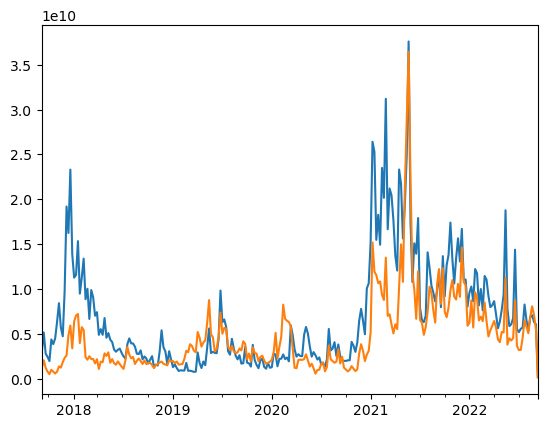

In [97]:
df_pivoted2['Bitcoin'].resample('W').sum().plot()
df_pivoted2['Ethereum'].resample('W').sum().plot()

In welchem der letzten 12 Monate wurde insgesamt am meisten mit Bitcoin gehandelt? Mit Ethereum?

In [98]:
df_pivoted2['Bitcoin'].resample('MS').sum().sort_values(ascending=False).head(1)

2021-05-01    1.037900e+11
Name: Bitcoin, dtype: float64

In [99]:
df_pivoted2['Ethereum'].resample('MS').sum().sort_values(ascending=False).head(1)

2021-05-01    1.129096e+11
Name: Ethereum, dtype: float64

Wie viel Bitcoin und Ethereum wird im Durchschnitt an den sieben Wochentagen gehandelt? Barchart.

<AxesSubplot:>

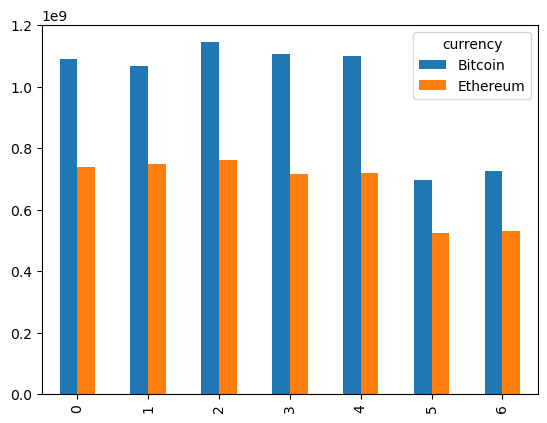

In [100]:
df_pivoted2[['Bitcoin', 'Ethereum']].groupby(df_pivoted2.index.weekday).mean().plot(kind='bar')

**Small Multiples**: Hier erstellen wir einen Plot, ähnlich wie oben

Kreieren Sie zuerst eine Liste von Währungen:
- Alle Währungen, die am letzten Handelstag einen Eintrag haben
- Sortiert in absteigender Reihenfolge nach dem Handelsvolumen
- Wir wählen nur die zehn grössten aus

In [101]:
sortierte_waehrungen = df_pivoted2.iloc[-1].sort_values(ascending=False).head(10)

In [102]:
len(sortierte_waehrungen)

10

In [103]:
sortierte_waehrungen

currency
Bitcoin         2.042904e+08
Ethereum        1.603006e+08
Tether          6.211561e+07
XRP             4.567335e+07
Solana          2.721383e+07
Binance Coin    1.573735e+07
Cardano         1.374209e+07
Polygon         1.301791e+07
Chainlink       1.171228e+07
Cosmos          1.133925e+07
Name: 2022-09-05 00:00:00, dtype: float64

Und jetzt: Small Multiples plotten! Überlegen Sie sich:
- Wie viele Subplots braucht es, wie sollen sie angeordnet sein?
- Wie gross muss die Abbildung insgesamt sein?
- Was ist eine sinnvolle Einstellung für die Y-Achse?

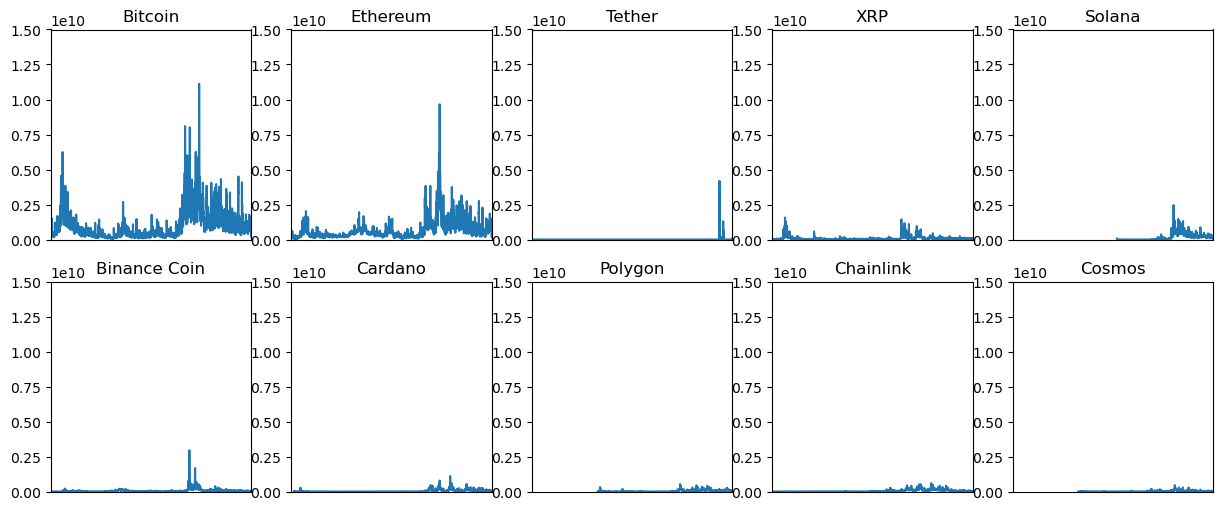

In [104]:
# Eine Abbildung, die gross genug ist
fig = plt.figure(figsize=(15,6))

# Und nun, für jede einzelne Währung:
for i, waehrung in enumerate(sortierte_waehrungen.index):
    
    # einen Subplot kreieren ...
    ax = fig.add_subplot(2, 5, i + 1)

    # ... und mit Inhalt füllen
    df_pivoted2[waehrung].plot(title=waehrung, ax=ax)
    
    # Auf Ticks verzichten wir hier ganz
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.xaxis.set_minor_locator(ticker.NullLocator())
    
    ax.set_ylim([0, 1.5e10])

Alternative syntax dafür:

(0.0, 15000000000.0)

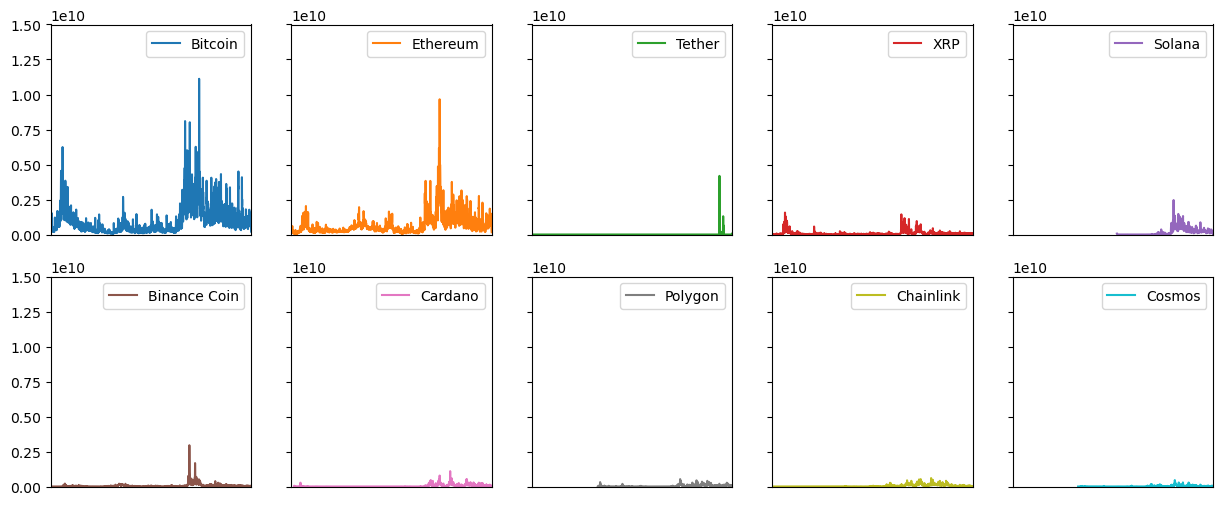

In [105]:
axes = df_pivoted2[sortierte_waehrungen.index].plot(subplots=True,layout=(2,5), sharey=True, figsize=(15,6))

axes[0,0].xaxis.set_major_locator(ticker.NullLocator())
axes[0,0].xaxis.set_minor_locator(ticker.NullLocator())
axes[0,0].set_ylim([0, 1.5e10])